## Proteccion - Quantum Computing
# Optimización de Portfolio

## Introduccion: Que es optimización de Portfolio?
Optimización de portfolio es un proceso crucial para cualquier persona que desee maximizar la rentabilidad de sus inversiones.
Las inversiones suelen ser un set de los activos (acciones, créditos, bonos, derivados, opciones de compra, venta, etc.) y esta colección de activos se denomina **Portfolio**.
<center><img src="../src/ex1-01.png" width="270"></center>
El objetivo de la optimización de portfolio es minimizar los riesgos (pérdida financiera) y maximizar los rendimientos (ganancia financiera). Pero este proceso no es tan sencillo como puede parecer. Obtener altos rendimientos con poco riesgo es, de hecho, demasiado bueno para ser verdad. Los riesgos y los rendimientos suelen tener una relación de compensación que hace que la optimización de su cartera sea un poco más complicada. Como afirma el Dr. Harry Markowitz en su Modern Portfolio Theory que creó en 1952, "el riesgo es una parte inherente de una mayor recompensa".

## Encontrar la frontera eficiente
La teoría moderna de portfolio (MPT) sirve como marco general para determinar una cartera ideal para los inversores. La MPT también se conoce como teoría de la cartera de media-varianza porque supone que cualquier inversor elegirá la cartera óptima del conjunto de carteras que:
- Maximiza el rendimiento esperado para un nivel de riesgo dado; y
- Minimiza los riesgos para un determinado nivel de rentabilidad esperada.

La siguiente figura muestra la frontera de varianza mínima de la teoría de cartera moderna, donde el eje horizontal muestra el riesgo y el eje vertical muestra el rendimiento esperado.

<center><img src="src/ex1-02.png" width="400" height="400"/></center>

Los inversores nunca querrán tener una cartera por debajo del punto mínimo de varianza. Siempre obtendrán rendimientos más altos a lo largo de la parte con pendiente positiva de la frontera de varianza mínima. Y la parte con pendiente positiva de la frontera de varianza mínima se denomina **frontera eficiente**.

La **frontera eficiente** es donde se encuentran las carteras óptimas. Y ayuda a reducir las diferentes carteras entre las que puede elegir el inversor.

## ¿Cómo podemos formular este problema?<br>
La función que describe la frontera eficiente se puede formular en un programa cuadrático con restricciones lineales como se muestra a continuación. <br>
Los términos que están marcados en rojo están asociados a riesgos y los términos en azul están asociados a rendimientos.
Puede ver que nuestro objetivo es minimizar la compensación entre riesgo y rendimiento. En general, la función que queremos optimizar se llama función objetivo. <br> <br>

<div align="center"> <font size=5em >$\min_{x \in \{0, 1\}^n}: $</font> <font color='red', size=5em >$q x^n\Sigma x$</font> - <font color='blue', size=5em>$\mu^n x$</font> </div>

<div align="center"> <font size=5em >$sujeto$</font> <font size=5em >$a: 1^n x = B$</font> </div>

- <font size=4em >$x$</font> indica asignación de activos.
- <font size=4em >$Σ$</font> (sigma) es una matriz de covarianza.
Una matriz de covarianza es un concepto matemático útil que se aplica ampliamente en el mundo financiero. Es una medida estadística de cómo varían los precios de dos activos entre sí. Cuando la covarianza entre dos acciones es alta, significa que una acción experimenta fuertes movimientos de precios y es volátil si cambia el precio de la otra acción.
- <font size=4em >$q$</font> se denomina factor de riesgo (tolerancia al riesgo), que es una evaluación de la voluntad o la capacidad de una persona para asumir riesgos. Por ejemplo, cuando utilizas los servicios de asesoramiento financiero automatizado, los llamados robo-advising, normalmente verás diferentes niveles de tolerancia al riesgo. Valor entre 0 y 1.
- <font size=4em >$𝝁$</font> (mu) es el rendimiento esperado y lo que queremos maximizar.
- <font size=4em >$n$</font> es la cantidad de activos diferentes entre los que podemos elegir
- <font size=4em >$B$</font> Presupuesto,en este contexto significa la cantidad de activos que podemos asignar en nuestra cartera.


## Qiskit Finance
<center><img src="src/qiskit.png" width="900" height="900"/></center>

In [49]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal,EfficientSU2
from qiskit.utils import QuantumInstance,algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer ,CplexOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta, datetime
import warnings
import mplfinance as mpl

## Descarga de datos en Binance
Para nuestra demo utilizaremos datos de criptomonedas,que descargaremos utilizando la API de Binance.
<center><img src="src/binance.png" width="300" height="300"/></center>
Las criptomomendas utilizadas en esta demo:

- Bitcoin
- Ethereum
- BNB
- Solana
- Cardano
- XRP
- Polkdadot
- Doge

Descargaremos los datos de los ultimos 356 días y tomaremos el valor de cierre por día.

In [5]:
#Client API configuration
from dotenv import load_dotenv
load_dotenv()
import os
API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

In [6]:
from binance.client import Client

In [7]:
client = Client(API_KEY,API_SECRET)

In [10]:
info = pd.DataFrame(client.get_all_tickers())

In [11]:
##Get all the cryptocurrencies with USDT conversion.

assets = ['BNBUSDT','BTCUSDT','ETHUSDT','SOLUSDT','ADAUSDT','XRPUSDT','DOTUSDT','DOGEUSDT']
#assets = [symbol for symbol in info['symbol'] if 'USDT' in symbol]


#start="2020.10.23"
days = 365
#end = (datetime.today()-timedelta(days=1)).strftime("%Y.%m.%d")
start = (datetime.today()-timedelta(days=days)).strftime("%Y.%m.%d")
end = (datetime.today()).strftime("%Y.%m.%d")
timeframe="1d"

In [12]:
#Filter only CC with 366 days

df = pd.DataFrame()
for asset in assets:
    df_aux= pd.DataFrame(client.get_historical_klines(asset, timeframe,start,end))
    if len(df_aux) == (days+1):
        df_aux=df_aux.iloc[:,:6]
        df_aux.columns=["Date","Open","High","Low","Close","Volume"]
        df_aux.insert(1, "asset", asset, allow_duplicates=False)
        df = df.append(df_aux)

df['Date']=pd.to_datetime(df['Date'],unit="ms")
df.set_index('Date',inplace = True)
df.iloc[:,1:6]=df.iloc[:,1:6].astype("float")
assets = df['asset'].unique()

In [13]:
df

,asset,Open,High,Low,Close,Volume
Date,,,,,,
2021-03-06,BNBUSDT,225.5391,232.4996,219.1514,226.3814,2.663376e+06
2021-03-07,BNBUSDT,226.3812,243.9500,224.9542,240.1100,3.519963e+06
2021-03-08,BNBUSDT,240.1039,243.0986,228.7029,240.5509,3.045992e+06
2021-03-09,BNBUSDT,240.7852,297.2962,235.6001,293.2052,7.937299e+06
2021-03-10,BNBUSDT,293.1305,295.5000,263.8184,278.4499,6.012304e+06
...,...,...,...,...,...,...
2022-03-02,DOGEUSDT,0.1340,0.1373,0.1306,0.1330,6.725115e+08
2022-03-03,DOGEUSDT,0.1330,0.1339,0.1271,0.1297,5.234962e+08
2022-03-04,DOGEUSDT,0.1297,0.1302,0.1200,0.1226,6.603100e+08


In [9]:
assets

array(['BNBUSDT', 'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'ADAUSDT', 'XRPUSDT',
       'DOTUSDT', 'DOGEUSDT'], dtype=object)

In [19]:
print(f"Cantidad de criptomonedas:{len(assets)}")

Cantidad de criptomonedas:8


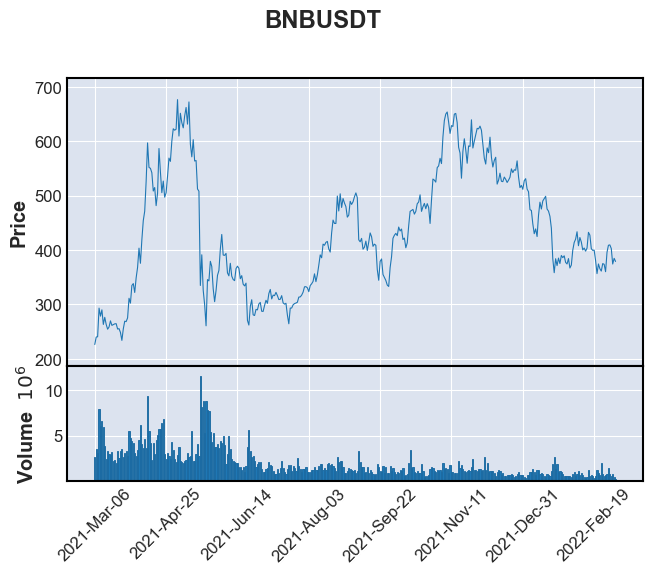

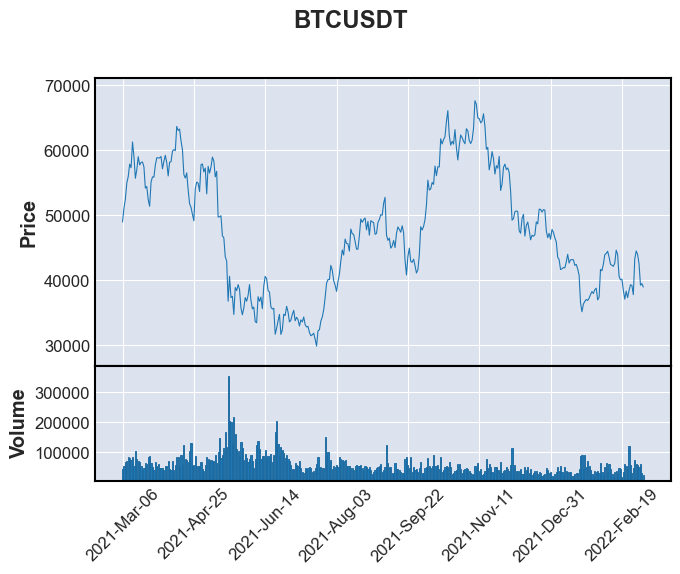

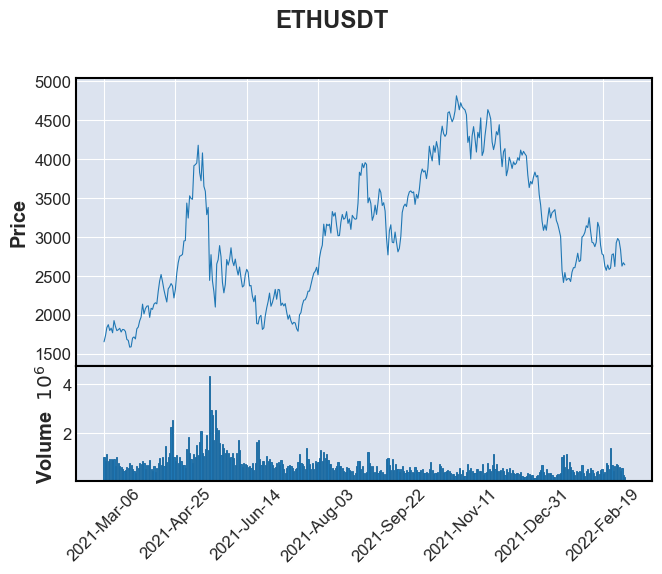

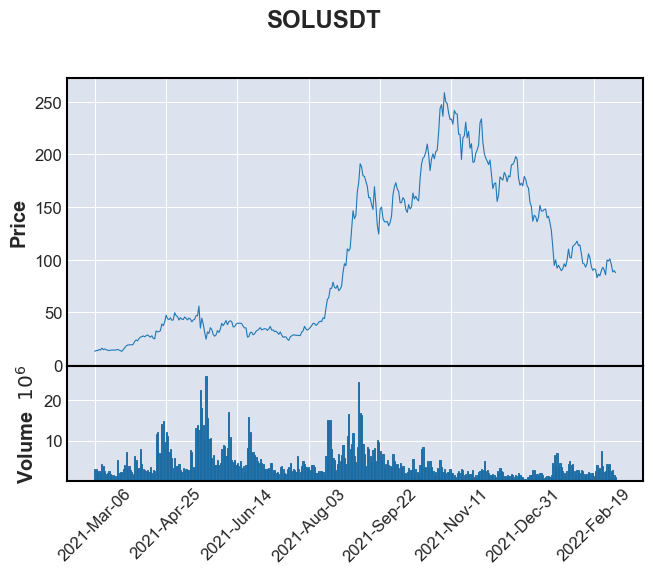

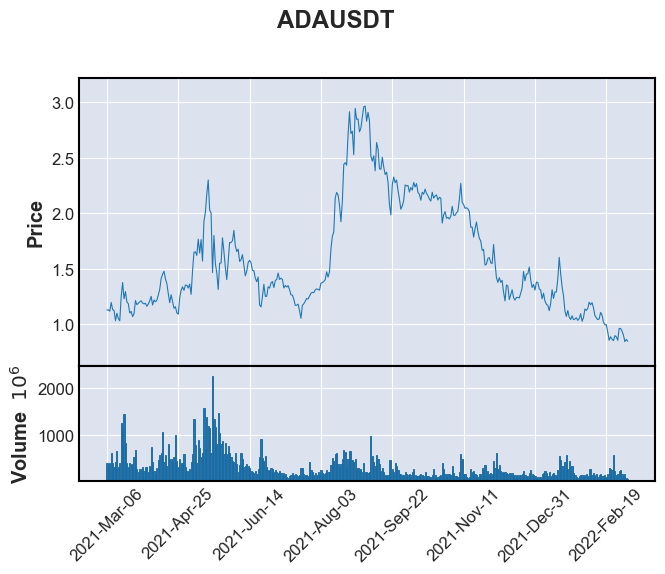

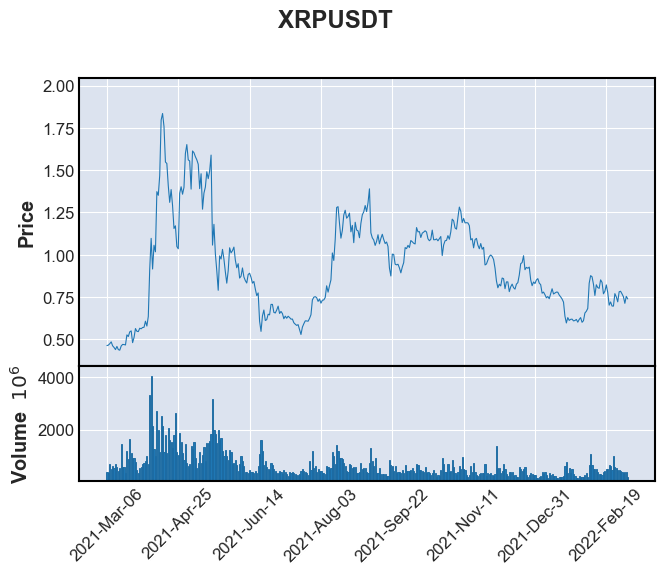

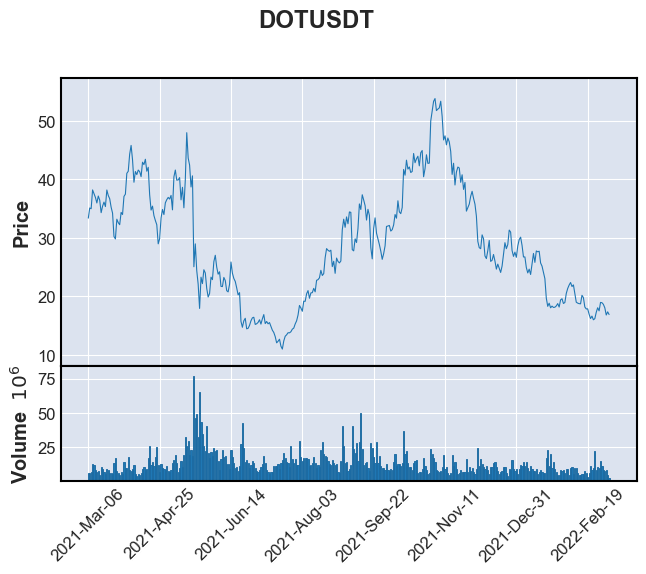

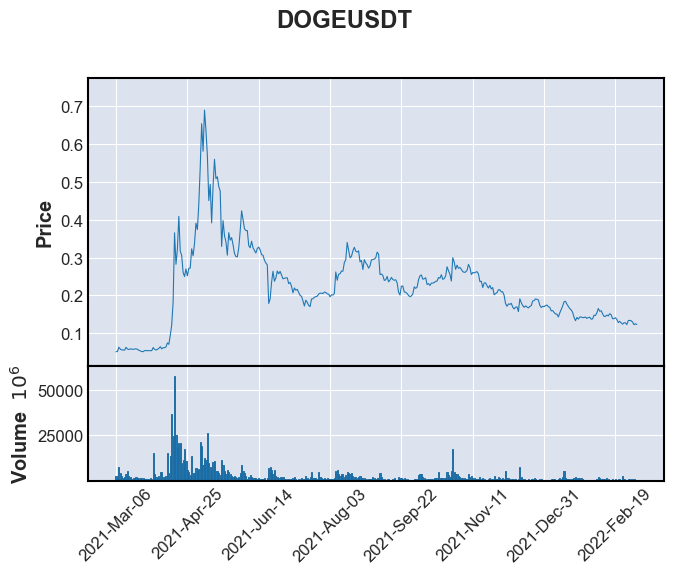

In [20]:
#Plot trends

for asset in assets:    
    #mpl.plot(df[df['asset'] == asset], type='candle', volume=True, mav=7,title=asset)
    mpl.plot(df[df['asset'] == asset], type='line', volume=True,title=asset)

In [21]:
#Calcular mu y sigma

mu = {}
retornos = []
retornos_x = []

for asset in assets:
    lista = np.array(df[df['asset'] == asset]['Close'])
    retornos = (lista[1:]/lista[:-1])-1
    mu[asset] = np.average(retornos)
    retornos_x.append(retornos)
    #retornos_x = retornos_x.append(retornos)
#x = np.vstack([retornos_x[0],retornos_x[1],retornos_x[2],retornos_x[3],retornos_x[4],retornos_x[5],retornos_x[6],retornos_x[7]])
x = np.vstack(retornos_x)
sigma = np.cov(x)

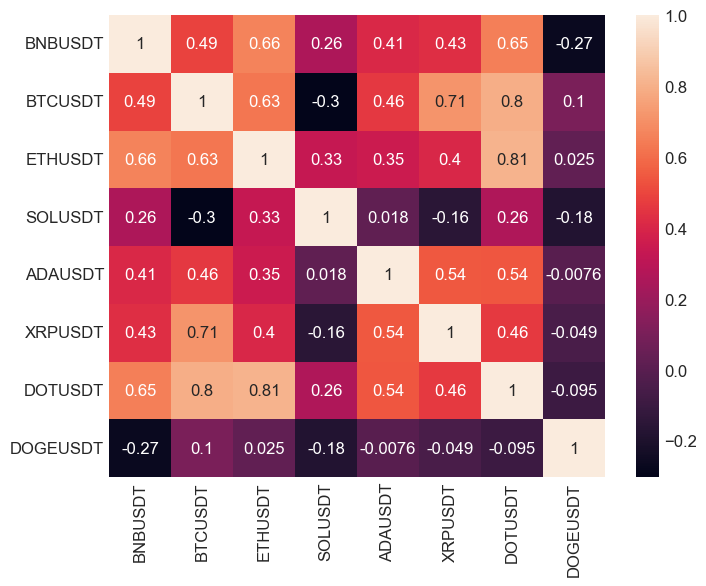

In [22]:
corr_df = pd.DataFrame(sigma).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True,xticklabels=assets, yticklabels=assets)
plt.show()

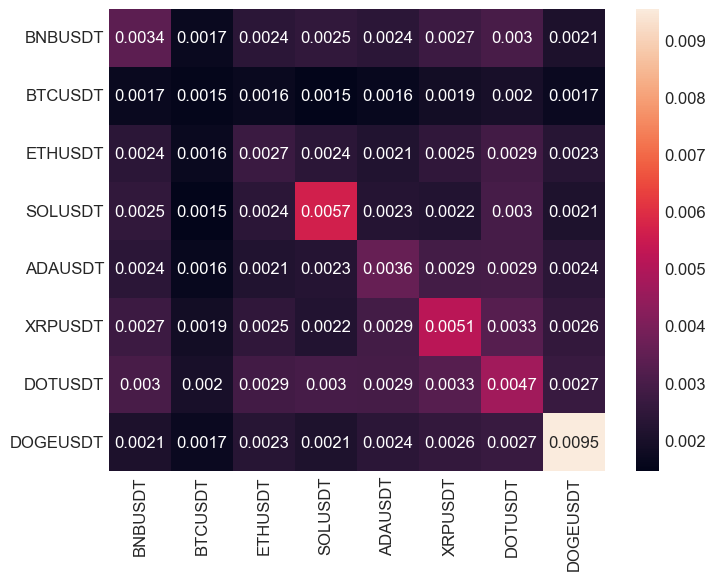

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(sigma, annot=True,xticklabels=assets, yticklabels=assets)
plt.show()

In [47]:
#Build QUBO function to optimize

num_assets = len(assets)     
q = 0.5                  
budget = round(len(assets)*0.2)       
seed = 19900330  

#portfolio = PortfolioOptimization(expected_returns=[item for item in mu.values()], covariances=sigma, risk_factor=q, budget=budget,bounds=[[0,2]]*len(assets))
portfolio = PortfolioOptimization(expected_returns=[item for item in mu.values()], covariances=sigma, risk_factor=q,budget=budget)

qp = portfolio.to_quadratic_program()

##############################
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.003124708810 x_0 - 0.000134480362 x_1 - 0.002642736426 x_2
      - 0.008047770430 x_3 - 0.000975680417 x_4 - 0.003762424689 x_5
      - 0.000521501415 x_6 - 0.006537518416 x_7 + [ 0.003390764567 x_0^2
      + 0.003329909635 x_0*x_1 + 0.004786184303 x_0*x_2 + 0.004996732451 x_0*x_3
      + 0.004788644368 x_0*x_4 + 0.005448984828 x_0*x_5 + 0.005943247677 x_0*x_6
      + 0.004162929574 x_0*x_7 + 0.001525814498 x_1^2 + 0.003293555275 x_1*x_2
      + 0.002905553949 x_1*x_3 + 0.003227271620 x_1*x_4 + 0.003712556238 x_1*x_5
      + 0.003935411094 x_1*x_6 + 0.003356029859 x_1*x_7 + 0.002697160964 x_2^2
      + 0.004780976153 x_2*x_3 + 0.004299339913 x_2*x_4 + 0.004949056725 x_2*x_5
      + 0.005700206234 x_2*x_6 + 0.004599133417 x_2*x_7 + 0.005652359838 x_3^2
      + 0.004545507130 x_3*x_4 + 0.004392986653 x_3*x_5 + 0.005922503442 x_3*x_6
      + 0.004176608636 x_3*x_7 + 0.

## Algoritmo 1 - Programación Lineal con Cplex (Método Simplex) - Clásico

In [39]:
%%time

###Classical Optimizer CPLEX###

algorithm_globals.random_seed = 1990
cplex_optimizer = CplexOptimizer()
cplex_result = cplex_optimizer.solve(qp)

print(cplex_result)

optimal function value: -0.004902175114339399
optimal value: [0. 0. 0. 1. 0. 0. 0. 1.]
status: SUCCESS
CPU times: user 18.8 ms, sys: 31.3 ms, total: 50.1 ms
Wall time: 64.8 ms


## Algoritmo 2 - Variational Quantum Eigensolver (VQE) - Hibrido Cúantico y Clásico
<center><img src="src/vqe.png" width="800" height="800"/></center>

In [54]:
%%time

###VQE###


num_qubits = len(assets) 
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True)

print(ansatz)

algorithm_globals.random_seed = 1990
backend = Aer.get_backend('qasm_simulator')
optimizer = SLSQP()  

vqe = VQE(ansatz = ansatz ,optimizer=optimizer, quantum_instance=backend)

vqe_meo = MinimumEigenOptimizer(vqe)
result = vqe_meo.solve(qp)

print(result)  

     ┌──────────┐ ┌──────────┐ ░                                     ░ »
q_0: ┤ Ry(θ[0]) ├─┤ Rz(θ[8]) ├─░───■─────────────────────────────────░─»
     ├──────────┤ ├──────────┤ ░ ┌─┴─┐                               ░ »
q_1: ┤ Ry(θ[1]) ├─┤ Rz(θ[9]) ├─░─┤ X ├──■────────────────────────────░─»
     ├──────────┤┌┴──────────┤ ░ └───┘┌─┴─┐                          ░ »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[10]) ├─░──────┤ X ├──■───────────────────────░─»
     ├──────────┤├───────────┤ ░      └───┘┌─┴─┐                     ░ »
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[11]) ├─░───────────┤ X ├──■──────────────────░─»
     ├──────────┤├───────────┤ ░           └───┘┌─┴─┐                ░ »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[12]) ├─░────────────────┤ X ├──■─────────────░─»
     ├──────────┤├───────────┤ ░                └───┘┌─┴─┐           ░ »
q_5: ┤ Ry(θ[5]) ├┤ Rz(θ[13]) ├─░─────────────────────┤ X ├──■────────░─»
     ├──────────┤├───────────┤ ░                     └───┘┌─┴─┐      ░ »
q_6: ┤ Ry(θ[6]) ├┤ Rz(θ[14]) ├─░───────────────────

## Algoritmo 3 - Quantum Approximate Optimization Algorithm (QAOA) - Hibrido Cúantico y Clásico
<center><img src="src/qaoa.png" width="600" height="600"/></center>

In [57]:
%%time

##QAOA###

#algorithm_globals.massive=True
optimizer = COBYLA(|)  
#algorithm_globals.random_seed = 1990
backend = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
qaoa = QAOA(optimizer=optimizer,quantum_instance=backend)

qaoa_meo = MinimumEigenOptimizer(qaoa)

result = qaoa_meo.solve(qp)

print(result) 

optimal function value: -0.004902175114339399
optimal value: [0. 0. 0. 1. 0. 0. 0. 1.]
status: SUCCESS
CPU times: user 2.29 s, sys: 15.3 ms, total: 2.31 s
Wall time: 2.32 s
